<a href="https://colab.research.google.com/github/jbarsce/AprendizajePorRefuerzos/blob/master/lab_1_intro_rl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook 1: Introducción al aprendizaje por refuerzos

Curso Aprendizaje por Refuerzos, Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones

FaMAF, 2023

## Introducción

En el siguiente notebook se muestra cómo ejecutar agentes de aprendizaje por refuerzos, los cuáles son necesarios para realizar este Lab.

### Repaso rápido



* Recompensa: señal $r$ recibida desde el entorno que recompensa o castiga el agente según su desempeño con respecto al objetivo de la tarea.

* Valor: función $v_\pi (s)$ que establece cuánto el agente espera percibir de recompensa al seguir la política $\pi$ partiendo desde el estado $s$. También se la suele expresar como $Q_\pi(s,a)$, indicando cuánto el agente espera percibir siguiendo la política $\pi$ partiendo desde el estado $s$ y siguiendo la acción $a$.

* Política: función $\pi(s) \to a$ que mapea un estado a una acción. Se suele expresar como probabilidad de elegir la acción $\pi(a \mid s)$. La política $\epsilon$-greedy, en donde $\epsilon$ es la probabilidad de exploración (normalmente menor que la probabilidad de explotación) está dada por $\pi(a \mid s) = 1 - \epsilon$ si $a$ es la mejor acción, caso contrario pasa a estar dada por $\pi(a \mid s) = \epsilon$.

Por otra parte, en la política Softmax, no se busca la acción con máxima probabilidad sino que se computa la probabilidad de cada una mediante la función Softmax y se realiza un sorteo entre ellas pesado por la misma. Así, para cada acción $a$, $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

En este notebook vemos dos algoritmos para actualizar la función de valor (y, por lo tanto, la política de selección de acciones):

* Actualización por SARSA (on-policy).

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo SARSA](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/sarsa.png?raw=1)


* Actualización por Q-Learning (off-policy)

$$Q(s,a) \gets Q(s,a) + \alpha (r + \gamma \arg\max_{a'} Q(s',a') - Q(s,a))$$

Algoritmo completo (a modo de referencia):

![Algoritmo Q-Learning](https://github.com/DiploDatos/AprendizajePorRefuerzos/blob/master/images/q_learning.png?raw=1)

Fuente de las imágenes: capítulo 6 de [Reinforcement Learning: An Introduction](http://www.incompleteideas.net/book/the-book.html).

## Librería a usar: Librería OpenAI Gym

[OpenAI Gym](https://gym.openai.com/) (Brockman et. al., 2016) es una librería de OpenAI que ofrece entornos y una interfaz estándar con la cuál probar nuestros agentes. Su objetivo es proveer benchmarks unificados para ver el desempeño de algoritmos en el entorno y así poder saber con facilidad cómo es su desempeño comparado con los demás. Parte de la siguiente sección está basada en la [documentación oficial de OpenAI](https://gym.openai.com/docs/).

La interfaz principal de los ambientes de gym es la interfaz Env. La misma posee cinco métodos principales:

* ```reset(self, seed)``` : Reinicia el estado del entorno, a su estado inicial, devolviendo una observación de dicho estado. Opcionalmente, establece la semilla aleatoria del generador de números aleatorios del presente entorno.

* ```step(self, action)``` : "Avanza" un timestep del ambiente. Devuelve: ```observation, reward, terminated, truncated, info```.

* ```render(self)``` : Muestra en pantalla una parte del ambiente.

* ```close(self)``` : Finaliza con la instancia del agente.


Por otra parte, cada entorno posee los siguientes tres atributos principales:

* ```action_space``` : El objeto de tipo Space correspondiente al espacio de acciones válidas.

* ```observation_space``` : El objeto de tipo Space correspondiente a todos los rangos posibles de observaciones.

* ```reward_range``` : Tupla que contiene los valores mínimo y máximo de recompensa posible.

Algunas de las ejecuciones contienen videos. Para poder verlos se necesita previamente instalar la librería ffmpeg; para instalarla desde Linux ejecutar en consola

```apt-get install ffmpeg```

desde Mac, reemplazar *apt-get* por *brew*

desde Windows, descargarla desde

[https://ffmpeg.org/download.html](https://ffmpeg.org/download.html)

(Nota: las animaciones son a modo ilustrativo, si no se desea instalar la librería se puede directamente eliminar la línea de código donde se llama al método ``env.render(mode='human')``)

Código básico de importación y funciones de graficación (no modificar)

In [274]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

Ejemplo: agente CartPole

In [275]:
from IPython.display import clear_output

try:
  import google.colab
  IN_COLAB = True

  !pip install gymnasium

except:
  IN_COLAB = False

import gymnasium as gym

# no es posible mostrar videos de ejecución del agente desde Colab
if not IN_COLAB:

    env = gym.make('CartPole-v0')
    env.reset()
    env.render()

    for _ in range(500):
        env.render()
        # se ejecuta una acción aleatoria
        obs, reward, terminated, truncated, info = env.step(
           env.action_space.sample())

        done = terminated or truncated
        if done:
            env.reset()
    env.close()
    clear_output()

Ejemplo: agente Mountain Car

In [276]:
if not IN_COLAB:
    env = gym.make('MountainCar-v0')
    obs = env.reset()
    for t in range(500):
        env.render()
        action = env.action_space.sample()
        obs, reward, terminated, truncated, info = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
    env.close()
    clear_output()

## Ejemplo 1: The Cliff.


![](https://github.com/GIDISIA/RLDiplodatos/blob/master/images/cliffwalking.png?raw=1)

donde S= starting point, G= goal

(imagen de Sutton y Barto, 2018)

Descripción del entorno:

Acciones:

* $\uparrow$ - Arriba
* $\downarrow$ - Abajo
* $\rightarrow$ - Derecha
* $\leftarrow$ - Izquierda

Función de recompensa:

* $-1$ en todos los demás estados
* $-100$ en el acantilado

Nota: caer en el acantilado devuelve al agente al estado inicial en un mismo episodio

Vemos los bloques básicos de nuestro agente

Definimos el método de elección de acciones. En este caso el mismo utiliza la política de exploración $\epsilon$-greedy.

In [277]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

In [278]:
def choose_action_softmax() -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política softmax
    """

    # TODO: implementar
    pass

Definimos el esqueleto del método learn, el cuál toma una transición y cambia el dict de los valores de Q de acuerdo a algún algoritmo.

In [279]:
def learn_SARSA(
        state: Any, # COMPLETAR tipo de cada parámetro
        action: Any,
        reward: Any,
        next_state: Any,
        next_action: Any,
        hyperparameters: Any,
        q: Any,
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada
    Args:
        state: COMPLETAR
        action: COMPLETAR
        reward: COMPLETAR
        next_state: COMPLETAR
        next_action: COMPLETAR
        hyperparameters: COMPLETAR
        q: COMPLETAR
    """

    # TODO - completa con tu código aquí

    pass

In [280]:
# completar argumentos de la función para hacer una actualización Q-learning
def learn_Q_learning(
        # COMPLETAR
) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning, para una transición
    de estado dada
    Args: COMPLETAR
    """

    # TODO - completa con tu código aquí

    pass

Finalmente, definimos el método principal de iteraciones.

In [281]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,
                hyperparameters,
                q
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

Definidos los métodos básicos, procedemos a instanciar a nuestro agente.

In [282]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}


# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA #Acá puedo poner learn_SARSA o learn_Q_learning porque le di los mismos argumentos a ambas. Sino no se podía.
episodes_to_run = 500

env = gym.make("CliffWalking-v0")
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

Ya instanciado, ejecutamos nuestro agente

In [283]:
avg_steps_per_episode, timesteps_ep, reward_ep = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

### Análisis de la ejecución del agente

#### Análisis de convergencia

A diferencia de lo que sucede en el aprendizaje supervisado, en el aprendizaje por refuerzos el rendimiento se evalúa por una función específica que es la función de recompensa. En la práctica, la función de recompensa puede ser externa (y provista por el entorno) o bien puede ser una función creada por diseño (a modo de dirigir el agente hacia lo que por diseño se considera mejor, en nuestro ejemplo podría ser con una recompensa de $+1$ cada vez que el agente llega al estado objetivo). Esto se conoce como *reward shaping*, y hay que tener mucho cuidado con los posibles efectos secundarios de su uso.

Como el objetivo de RL es maximizar la recompensa obtenida, es posible utilizar la información sobre la obtención de la recompensas en cada time-step o episodio para evaluar el rendimiento parcial del agente (esto depende mucho de la particularidad de la distribución de la recompensa para el problema tratado).

Para analizar la ejecución del agente, vamos a ver cómo se desempeñó el mismo en dos curvas:

* Recompensa obtenida en cada episodio: nos dirá cuánta recompensa obtuvo el agente sumando cada una de recompensas individuales de cada episodio. Con esta medida podremos tener una noción de cómo se desempeñó esquivando el acantilado y llegando lo antes posible a la meta.

* Pasos transcurridos en cada episodio: indicará cuántos pasos le ha llevado al agente la ejecución del episodio.

Se estila suavizar ambas curvas para apreciar mejor su progresión (aunque a veces suele analizarse la curva de pasos por episodio sin suavizar).

Veamos recompensa por episodio (recordar que en este entorno cada paso otorga una recompensa de $-1$ excepto al caer al acantilado, donde la recompensa es de $-100$)

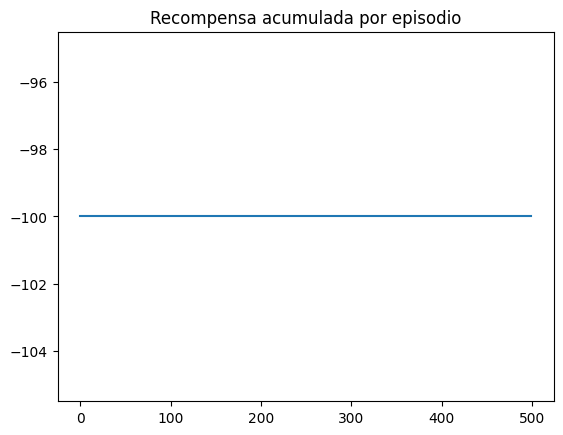

In [284]:
plot_reward_per_episode(reward_ep)

Veamos pasos por episodio

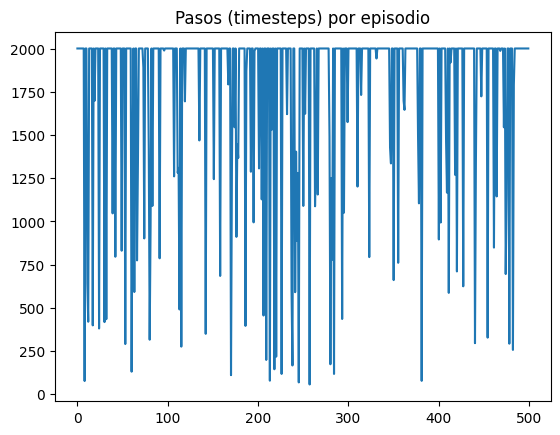

In [285]:
plot_steps_per_episode(timesteps_ep)

Suavizando...

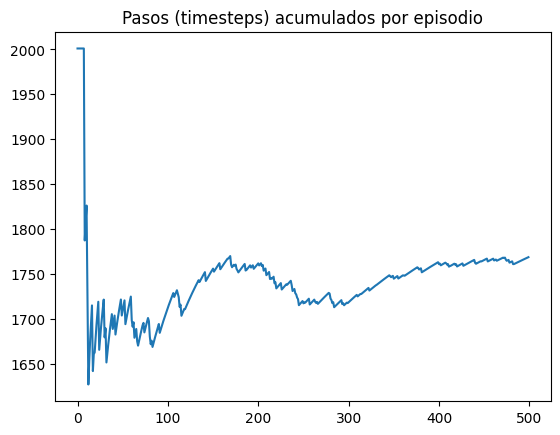

In [286]:
plot_steps_per_episode_smooth(timesteps_ep)

#### Análisis de matriz de acción-valor y política óptima

Siendo que este es un ejemplo tabular y de pocos estados / acciones, es posible realizar un análisis de convergencia desde otro punto de vista: desde el valor de la función $Q(s,a)$ para la mejor acción de cada estado, al finalizar el entrenamiento del agente, (sería la acción que el agente ejecutaría en cada estado bajo una política *greedy*). Ambos nos brindarán información sobre la convergencia alcanzada por el agente.

Tener en cuenta que este análisis se hace principalmente con fines educativos, para entornos más complejos el mismo puede no ser factible. En tales casos, un análisis alternativo podría consistir en hacer que el agente ejecute su política para la que fue entrenado, para hacer una evaluación a partir del comportamiento del mismo (esto último sería el *test de la política*, frente al *entrenamiento de la política* previo).

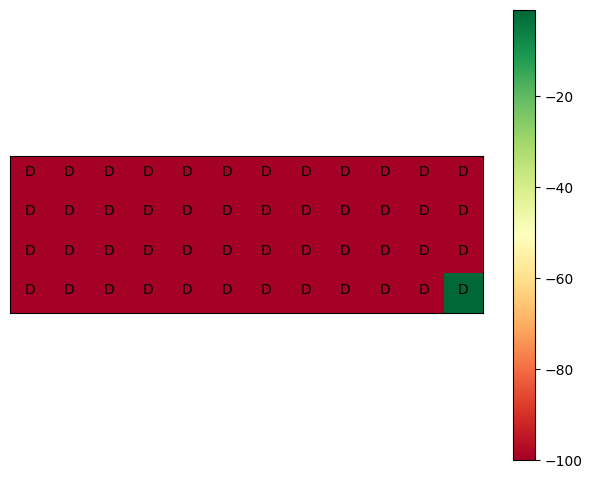


 Matriz de mejor acción-valor (en números): 

 [[-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.]
 [-100. -100. -100. -100. -100. -100. -100. -100. -100. -100. -100.   -1.]]


In [287]:
draw_value_matrix(q)

In [288]:
env.close()

## Actividades

1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".

2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.

3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.

4. (Opcional) Implementar política de exploración Softmax, en donde cada acción tiene una probabilidad $$\pi(a \mid s) = \frac{e^{Q(s,a)/\tau}}{\sum_{\widetilde{a} \in A}e^{Q(s,\widetilde{a})/\tau}}$$

5. (Opcional) Implementar Dyna-Q a partir del algoritmo Q-Learning, incorporando una actualización mediante un modelo. Comentar cómo se desempeña respecto a los demás algoritmos.


Para dejar el lab listo para su corrección, dejar link a repo de Github con un notebook ejecutando el agente en la planilla enviada en Slack.

FIN

## **Resolución**

Se puede correr iniciando desde aquí.

#### **Código básico de importación y funciones de graficación**

In [289]:
import gymnasium as gym

In [290]:
# @title Código básico importacion y utilerías (no modificar)

import itertools
from typing import Any, Callable, Tuple

import numpy as np
import matplotlib.pyplot as plt


def plot_reward_per_episode(reward_ep) -> None:
    episode_rewards = np.array(reward_ep)

    # se suaviza la curva de convergencia
    episode_number = np.linspace(
        1, len(episode_rewards) + 1, len(episode_rewards) + 1)
    acumulated_rewards = np.cumsum(episode_rewards)

    reward_per_episode = [
        acumulated_rewards[i] / episode_number[i]
        for i in range(len(acumulated_rewards))
    ]

    plt.plot(reward_per_episode)
    plt.title("Recompensa acumulada por episodio")
    plt.show()


def plot_steps_per_episode(timesteps_ep) -> None:
    # se muestra la curva de aprendizaje de los pasos por episodio
    episode_steps = np.array(timesteps_ep)
    plt.plot(np.array(range(0, len(episode_steps))), episode_steps)
    plt.title("Pasos (timesteps) por episodio")
    plt.show()


def plot_steps_per_episode_smooth(timesteps_ep) -> None:
    episode_steps = np.array(timesteps_ep)

    # se suaviza la curva de aprendizaje
    episode_number = np.linspace(
        1, len(episode_steps) + 1, len(episode_steps) + 1)
    acumulated_steps = np.cumsum(episode_steps)

    steps_per_episode = [
        acumulated_steps[i] / episode_number[i] for i in range(
            len(acumulated_steps))
    ]

    plt.plot(steps_per_episode)
    plt.title("Pasos (timesteps) acumulados por episodio")
    plt.show()


def draw_value_matrix(q) -> None:
    n_rows = 4
    n_columns = 12
    n_actions = 4

    # se procede con los cálculos previos a la graficación de la matriz de valor
    q_value_matrix = np.empty((n_rows, n_columns))
    for row in range(n_rows):
        for column in range(n_columns):
            state_values = []

            for action in range(n_actions):
                state_values.append(
                    q.get((row * n_columns + column, action), -100))

            maximum_value = max(
                state_values
            )  # determinamos la acción que arroja máximo valor

            q_value_matrix[row, column] = maximum_value

    # el valor del estado objetivo se asigna en -1 (reward recibido al llegar)
    # para que se coloree de forma apropiada
    q_value_matrix[3, 11] = -1

    # se grafica la matriz de valor
    plt.imshow(q_value_matrix, cmap=plt.cm.RdYlGn)
    plt.tight_layout()
    plt.colorbar()

    for row, column in itertools.product(
        range(q_value_matrix.shape[0]), range(q_value_matrix.shape[1])
    ):
        left_action = q.get((row * n_columns + column, 3), -1000)
        down_action = q.get((row * n_columns + column, 2), -1000)
        right_action = q.get((row * n_columns + column, 1), -1000)
        up_action = q.get((row * n_columns + column, 0), -1000)

        arrow_direction = "D"
        best_action = down_action

        if best_action < right_action:
            arrow_direction = "R"
            best_action = right_action
        if best_action < left_action:
            arrow_direction = "L"
            best_action = left_action
        if best_action < up_action:
            arrow_direction = "U"
            best_action = up_action
        if best_action == -1:
            arrow_direction = ""

        # notar que column, row están invertidos en orden en la línea de abajo
        # porque representan a x,y del plot
        plt.text(column, row, arrow_direction, horizontalalignment="center")

    plt.xticks([])
    plt.yticks([])
    plt.show()

    print("\n Matriz de mejor acción-valor (en números): \n\n", q_value_matrix)

#### **Política de exploración $\epsilon$-greedy**

In [291]:
def choose_action_e_greedy(
        state: int,
        actions: range,
        q: dict,
        hyperparameters: dict,
        random_state: np.random.RandomState,
) -> int:
    """
    Elije una acción de acuerdo al aprendizaje realizado previamente
    usando una política de exploración épsilon-greedy
    """
    # ej: para 4 acciones inicializa en [0,0,0,0]
    q_values = [q.get((state, a), 0.0) for a in actions]
    max_q = max(q_values)
    # sorteamos un número: es menor a épsilon?
    if random_state.uniform() < hyperparameters['epsilon']:
        # sí: se selecciona una acción aleatoria
        return random_state.choice(actions)

    count = q_values.count(max_q)

    # hay más de un máximo valor de estado-acción?
    if count > 1:
        # sí: seleccionamos uno de ellos aleatoriamente
        best = [i for i in range(len(actions)) if q_values[i] == max_q]
        i = random_state.choice(best)
    else:
        # no: seleccionamos el máximo valor de estado-acción
        i = q_values.index(max_q)

    return actions[i]

#### **Método principal de iteraciones**

Respecto a la versión que estaba en la consigna original, le agregamos un argumento más a la `learning_function`. 

El argumento adicional es `actions`. Y va a servir para la implementación de Q-Learning.

En total, la `learning_function` va a quedar con los siguientes argumentos:
*   state
*   action
*   reward
*   next_state
*   next_action (no va a ser de utilidad cuando corramos Q-Learning)
*   hyperparameters
*   q
*   actions (no va a ser de utilidad cuando corramos SARSA)

Esto lo hacemos para que al momento de instanciar al agente, en la variable `learning_function` podamos intercambiar fácilmente las funciones `learn_SARSA` con `learn_Q_learning`, sin alterar el resto del código.

In [292]:
def run(
    learning_function: Callable,
    hyperparameters: dict,
    episodes_to_run: int,
    env: gym.Env,
    actions: range,
    q: dict,
    random_state: np.random.RandomState,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Corre el algoritmo de RL para el ambiente FrozenLake-v0.
    Args:
        learning_function: función de actualización de algoritmo de aprendizaje
        hyperparameters: hiperparámetros del algoritmo de aprendizaje
        episodes_to_run: cantidad de episodios a ejecutar
        env: ambiente de Gymnasium
        actions: lista de acciones posibles
        q: diccionario de valores de estado-acción
        random_state: generador de números aleatorios
    """
    # registro de la cantidad de pasos que le llevó en cada episodio
    # llegar a la salida
    timesteps_of_episode = []
    # cantidad de recompensa que recibió el agente en cada episodio
    reward_of_episode = []

    for _ in range(episodes_to_run):
        # se ejecuta una instancia del agente hasta que el mismo
        # llega a la salida o tarda más de 2000 pasos

        # reinicia el ambiente, obteniendo el estado inicial del mismo
        state, _ = env.reset()

        episode_reward = 0
        done = False
        t = 0

        # elige una acción basado en el estado actual.
        # Filtra el primer elemento de state, que es el estado en sí mismo
        action = choose_action_e_greedy(
            state, actions, q, hyperparameters, random_state)

        while not done:
            # el agente ejecuta la acción elegida y obtiene los resultados
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_action = choose_action_e_greedy(
                next_state, actions, q, hyperparameters, random_state)

            episode_reward += reward
            learning_function(
                state,
                action,
                reward,
                next_state,
                next_action,
                hyperparameters,
                q,
                actions
            )

            done = terminated or truncated

            # if the algorithm does not converge, it stops after 2000 timesteps
            if not done and t < 2000:
                state = next_state
                action = next_action
            else:
                # el algoritmo no ha podido llegar a la meta antes de dar 2000 pasos
                done = True  # se establece manualmente la bandera done
                timesteps_of_episode = np.append(timesteps_of_episode, [int(t + 1)])
                reward_of_episode = np.append(
                    reward_of_episode, max(episode_reward, -100)
                )

            t += 1

    return reward_of_episode.mean(), timesteps_of_episode, reward_of_episode

### **1. Implementar y ejecutar el algoritmo SARSA en "The Cliff".**

**Definimos el método de aprendizaje SARSA:**

Cuando el agente experimenta una transición de estado-acción a estado'-acción', toma la recompensa observada y la utiliza para ajustar el valor Q del estado-acción actual (s, a) mediante la regla de actualización SARSA. La actualización se basa en la recompensa inmediata y el valor Q del próximo estado-acción (s', a') siguiendo la política actual del agente. El valor Q del estado-acción actual se actualiza en función de la diferencia entre esta recompensa y el valor Q esperado del próximo estado-acción.

In [293]:
def learn_SARSA(
    state: int,
    action: int,
    reward: float,
    next_state: int,
    next_action: int,
    hyperparameters: dict,
    q: dict,
    actions: list,
) -> None:
    """
    Realiza una actualización según el algoritmo SARSA, para una transición
    de estado dada.

    Args:
        state: El estado actual en el que se encuentra el agente.
        action: La acción tomada en el estado actual.
        reward: La recompensa recibida por tomar la acción.
        next_state: El estado resultante de tomar la acción.
        next_action: La próxima acción a tomar en el próximo estado.
        hyperparameters: Un diccionario que contiene hiperparámetros del algoritmo.
        q: Un diccionario que almacena los valores de Q para cada par (estado, acción).
        actions: La lista de acciones posibles en el entorno.
    """

    # Obtener los hiperparámetros
    alpha = hyperparameters['alpha']
    gamma = hyperparameters['gamma']

    # Calcular el valor Q actual y el valor Q del próximo estado-acción
    q_current = q.get((state, action), 0.0)
    q_next = q.get((next_state, next_action), 0.0)

    # Aplicar la regla SARSA para actualizar el valor Q
    updated_q = q_current + alpha * (reward + gamma * q_next - q_current)

    # Actualizar el valor Q en el diccionario
    q[(state, action)] = updated_q

Como se dijo anteriormente, `actions` no se utiliza.

**Instanciamos el agente**

In [294]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}

# se puede cambiar por learn_Q_learning, una vez que se implemente
learning_function = learn_SARSA #Acá puedo poner learn_SARSA o learn_Q_learning porque le di los mismos argumentos a ambas. Sino no se podía.
episodes_to_run = 500

env = gym.make("CliffWalking-v0", 
               #render_mode='human'
               )
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

**Ejecutamos el agente**

In [295]:
avg_steps_per_episode_SARSA_baseline, timesteps_ep_SARSA_baseline, reward_ep_SARSA_baseline = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

q_SARSA_baseline = q

#### **Análisis de la ejecución del agente**

##### **Análisis de convergencia**

**Recompensa por episodio**

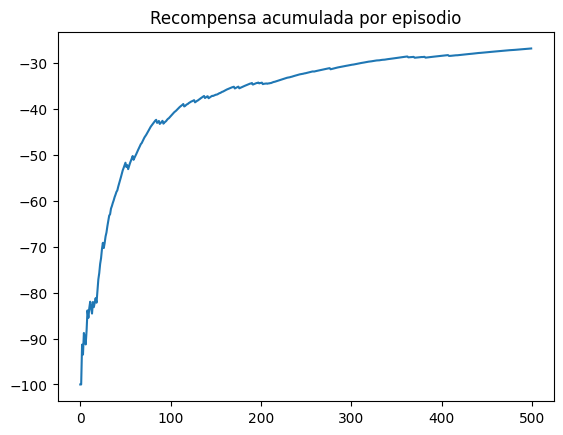

In [296]:
plot_reward_per_episode(reward_ep_SARSA_baseline)

**Pasos por episodio**

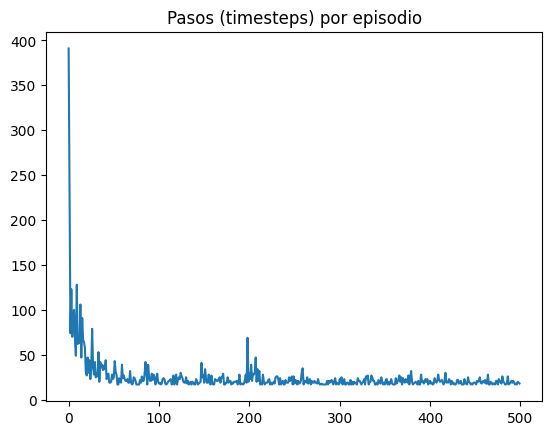

In [297]:
plot_steps_per_episode(timesteps_ep_SARSA_baseline)

**Pasos por episodio (suavizado)**

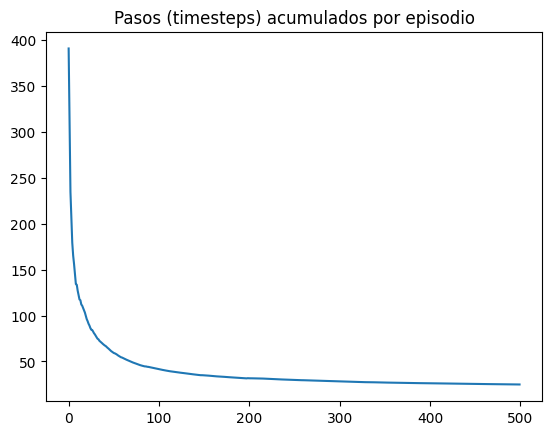

In [298]:
plot_steps_per_episode_smooth(timesteps_ep_SARSA_baseline)

##### **Análisis de matriz de acción-valor y política óptima**

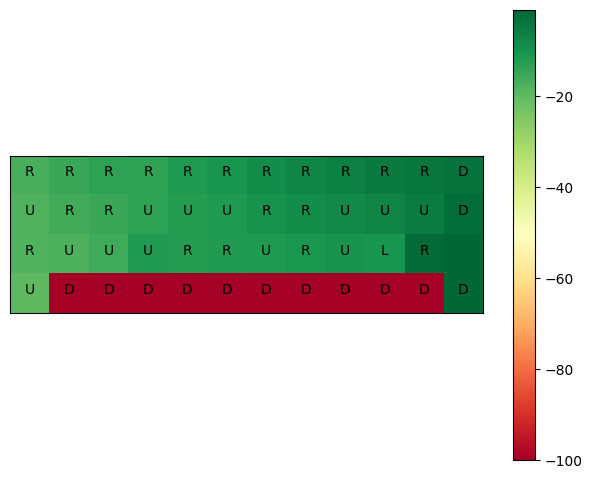


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [299]:
draw_value_matrix(q_SARSA_baseline)

In [300]:
env.close()

### **2. Implementar y ejecutar el algoritmo Q-Learning en "The Cliff". ¿Cómo converge con respecto a SARSA? ¿A qué se debe? Comentar.**

**Definimos el método de aprendizaje Q-Learning:**

Q-learning toma una transición de estado-acción a estado'-acción' y utiliza la recompensa observada para actualizar el valor Q del estado-acción actual (s, a) mediante la regla de actualización de Q-learning. En este caso, la actualización se basa en la recompensa inmediata y el valor Q máximo esperado del próximo estado-acción (s', a'). A diferencia de SARSA, Q-learning no sigue la política actual, sino que elige la acción futura que maximiza el valor Q. La actualización se centra en la diferencia entre la recompensa y el valor Q máximo esperado.

In [301]:
def learn_Q_learning(
    state: int,
    action: int,
    reward: float,
    next_state: int, 
    next_action: int,
    hyperparameters: dict,
    q: dict,
    actions: list,
) -> None:
    """
    Realiza una actualización según el algoritmo Q-learning, para una transición de estado dada
    Args:
        state: El estado actual en el que se encuentra el agente.
        action: La acción tomada en el estado actual.
        reward: La recompensa recibida por tomar la acción.
        next_state: El estado resultante de tomar la acción.
        next_action: La próxima acción a tomar en el próximo estado.
        hyperparameters: Un diccionario que contiene hiperparámetros del algoritmo.
        q: Un diccionario que almacena los valores de Q para cada par (estado, acción).
        actions: La lista de acciones posibles en el entorno.
    """
        
    # Obten los hiperparámetros
    alpha = hyperparameters['alpha']
    gamma = hyperparameters['gamma']

    # Calcula el valor Q actual y el valor Q máximo del próximo estado
    q_current = q.get((state, action), 0.0)
    q_max_next = max(q.get((next_state, a), 0.0) for a in actions)

    # Aplica la regla Q-learning para actualizar el valor Q
    updated_q = q_current + alpha * (reward + gamma * q_max_next - q_current)

    # Actualiza el valor Q en el diccionario
    q[(state, action)] = updated_q

Como se dijo anteriormente, `next_action` no se utiliza.

**Instanciamos el agente**

In [302]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}

learning_function = learn_Q_learning
episodes_to_run = 500

env = gym.make("CliffWalking-v0", 
               #render_mode='human'
               )
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

**Ejecutamos el agente**

In [303]:
avg_steps_per_episode_Q_Learning_baseline, timesteps_ep_Q_Learning_baseline, reward_ep_Q_Learning_baseline = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

q_Q_Learning_baseline = q

#### **Análisis de la ejecución del agente**

##### **Análisis de convergencia**

**Recompensa por episodio**

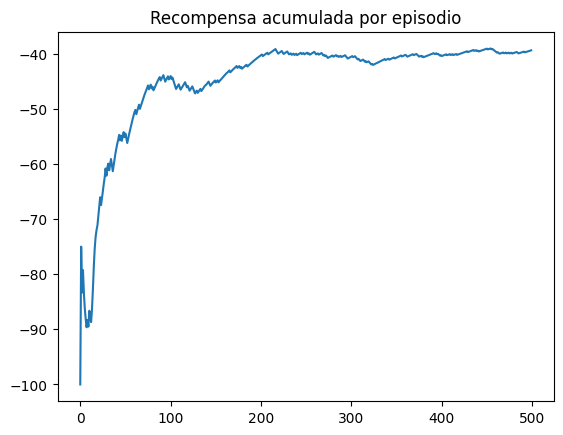

In [304]:
plot_reward_per_episode(reward_ep_Q_Learning_baseline)

**Pasos por episodio**

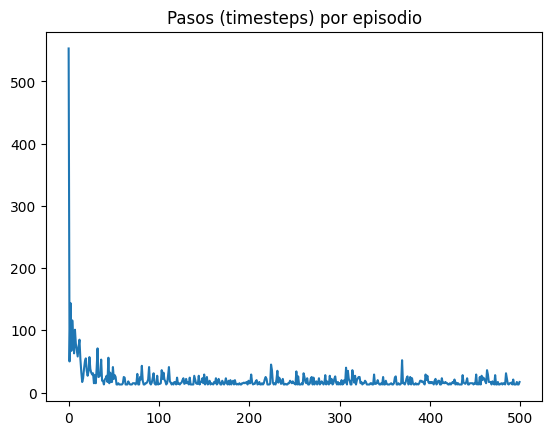

In [305]:
plot_steps_per_episode(timesteps_ep_Q_Learning_baseline)

**Pasos por episodio (suavizado)**

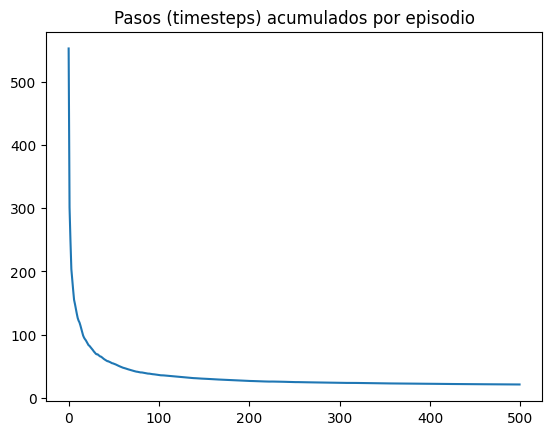

In [306]:
plot_steps_per_episode_smooth(timesteps_ep_Q_Learning_baseline)

##### **Análisis de matriz de acción-valor y política óptima**

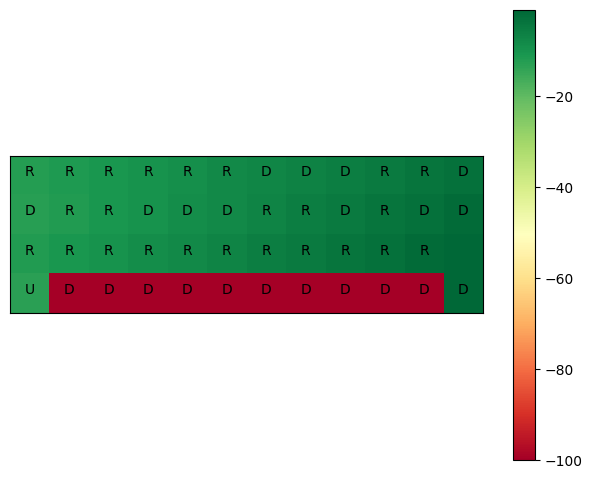


 Matriz de mejor acción-valor (en números): 

 [[ -12.3189387   -11.59140422  -10.84866451   -9.96310256   -9.18688713
    -8.34095048   -7.4542462    -6.72926453   -5.82792094   -4.91990551
    -3.95712468   -2.99947958]
 [ -12.87149892  -11.96404923  -10.98713428   -9.99742173   -8.99937844
    -7.99976186   -6.99991029   -5.99997592   -4.99999754   -3.99999928
    -2.99999988   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [307]:
draw_value_matrix(q_Q_Learning_baseline)

In [308]:
env.close()

#### **Comparación de algoritmos**

##### **Recompensa acumulada**

Recompensa acumulada por episodio

SARSA


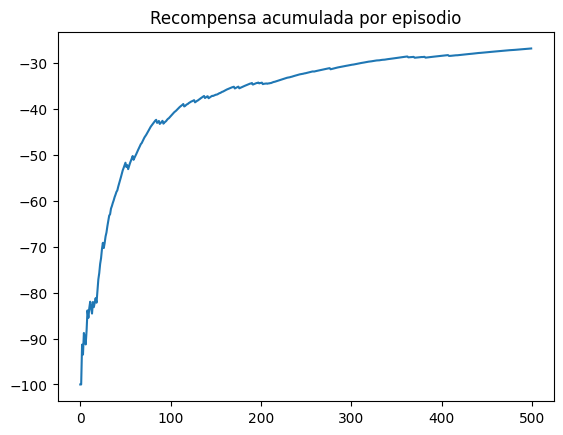


Q-Learning


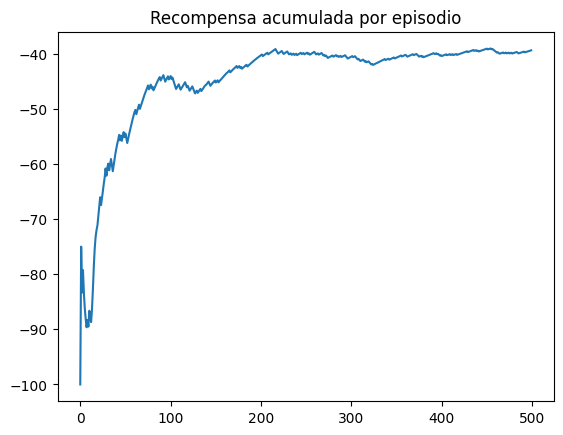

In [309]:
print('Recompensa acumulada por episodio')
print('')
print('SARSA')
plot_reward_per_episode(reward_ep_SARSA_baseline)
print('')
print('Q-Learning')
plot_reward_per_episode(reward_ep_Q_Learning_baseline)

*   **Forma de la curva:** A grandes rasgos, la recompensa acumulada es creciente a tasas decrecientes en ambos algoritmos. Al comienzo, el agente puede aprender rápidamente a través de la exploración y la retroalimentación de recompensas. Como resultado, la curva de recompensa aumenta de manera significativa. Con el tiempo, el agente podría haber explorado la mayoría de las estrategias posibles y alcanzado una política cercana a la óptima. A medida que se acerca a la política óptima, es probable que queden menos oportunidades para mejoras significativas en la recompensa.
*   **Suavidad**: Para SARSA la convergencia es más suave. En Q-Learning hay más saltos y volatilidad. SARSA tiende a explorar de manera más conservadora debido a su enfoque on-policy. Puede ser menos propenso a tomar decisiones arriesgadas. Q-Learning, al aprender la política óptima, a veces puede explorar de manera más agresiva, lo que puede llevar a recompensas altas o bajas de manera intermitente.
*   **Convergencia**: Q learning se estabiliza aproximadamente en un valor de -40. Al cual llega tras 200 episodios. SARSA llega a un nivel más alto de recompensa acumulada (-30). Al cual llega tras 300 episodios, y tas pasar 500 episodios aun parece tener margen para crecer.
En el diseño de este entorno, hay un castigo muy alto por caer en el acantilado. Como resultado, tomar políticas menos arriesgadas (SARSA) podría llevar a una recompensa acumulada más alta.
*   **Disclaimer**: Sin embargo, es importante mencionar que los resultados pueden variar dependiendo de la configuración de hiperparámetros y la aleatoriedad en el entorno.

##### **Pasos por episodio**

Pasos (timesteps) por episodio

SARSA


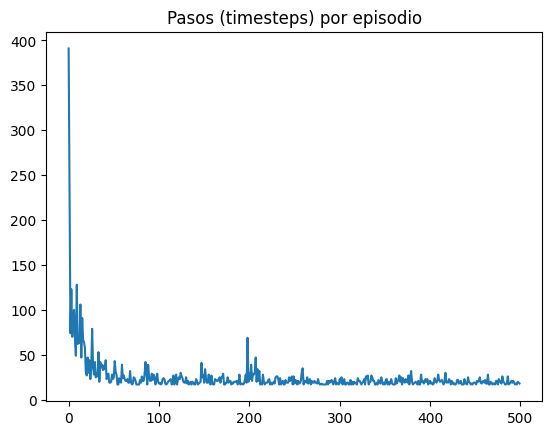


Q-Learning


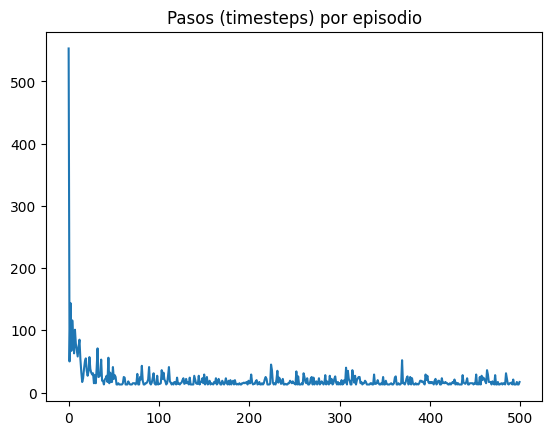

In [310]:
print('Pasos (timesteps) por episodio')
print('')
print('SARSA')
plot_steps_per_episode(timesteps_ep_SARSA_baseline)
print('')
print('Q-Learning')
plot_steps_per_episode(timesteps_ep_Q_Learning_baseline)

*  En los episodios iniciales, se observan más pasos en Q-Learning que en SARSA. Esto se debe a la naturaleza off-policy de Q-Learning, donde el agente puede explorar acciones no óptimas y arriesgadas. Sin embargo, a medida que avanza el aprendizaje y se aproxima a una política óptima, disminuye la cantidad de pasos necesarios para completar un episodio.
* Al llegar al último episodio, Q-Learning tiene menos pasos. A medida que Q-Learning converge hacia una política óptima, se espera que tome las acciones más eficientes para llegar a la meta en el menor número de pasos. Debido a su enfoque más conservador, SARSA podría ser más propenso a evitar el acantilado. Lo que lleva a un mayor número de pasos en el episodio final.

##### **Pasos acumulados por episodio**

Pasos (timesteps) acumulados por episodio

SARSA


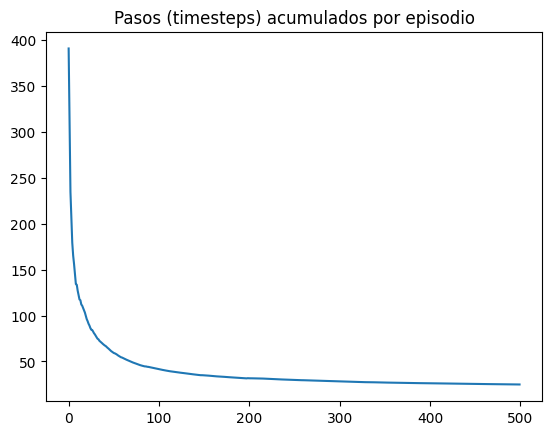


Q-Learning


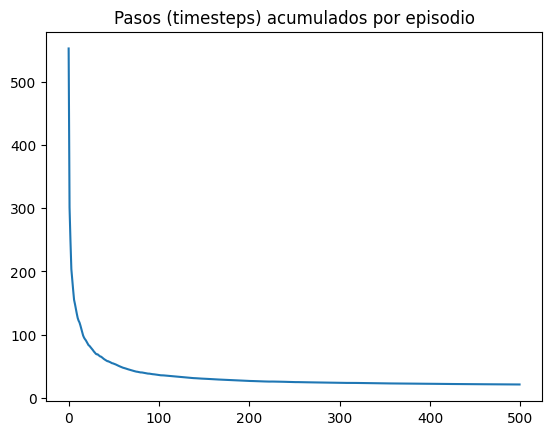

In [311]:
print('Pasos (timesteps) acumulados por episodio')
print('')
print('SARSA')
plot_steps_per_episode_smooth(timesteps_ep_SARSA_baseline)
print('')
print('Q-Learning')
plot_steps_per_episode_smooth(timesteps_ep_Q_Learning_baseline)

*  Se obtienen comentarios similares a los gráficos no suavizados.

##### **Análisis de matriz de acción-valor y política óptima**

Pasos (timesteps) acumulados por episodio

SARSA


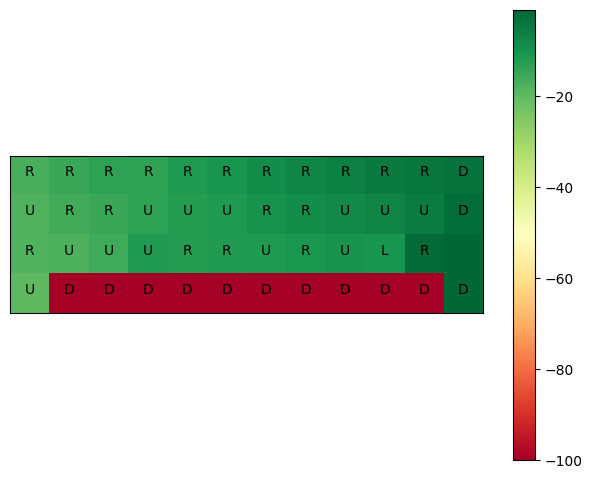


 Matriz de mejor acción-valor (en números): 

 [[ -17.23954428  -15.14316652  -13.47940719  -13.86734791  -11.50591433
   -10.42824021   -8.92910114   -7.36906975   -6.09772006   -5.02260286
    -4.246717     -3.48743802]
 [ -18.17688817  -16.29163152  -15.09887514  -13.57191616  -12.57200446
   -11.46204211  -10.28051994   -8.75636874   -8.02140089   -7.17268501
    -5.41325753   -2.24362335]
 [ -18.16818774  -17.96726471  -16.02741607  -12.12753358  -12.36502775
   -11.94064567  -11.56233996  -10.96253903   -9.96154144  -10.28531687
    -2.00258599   -1.        ]
 [ -19.72790699 -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]

Q-Learning


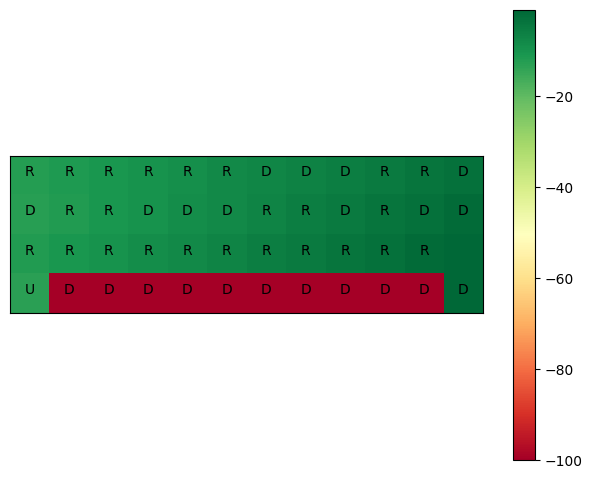


 Matriz de mejor acción-valor (en números): 

 [[ -12.3189387   -11.59140422  -10.84866451   -9.96310256   -9.18688713
    -8.34095048   -7.4542462    -6.72926453   -5.82792094   -4.91990551
    -3.95712468   -2.99947958]
 [ -12.87149892  -11.96404923  -10.98713428   -9.99742173   -8.99937844
    -7.99976186   -6.99991029   -5.99997592   -4.99999754   -3.99999928
    -2.99999988   -2.        ]
 [ -12.          -11.          -10.           -9.           -8.
    -7.           -6.           -5.           -4.           -3.
    -2.           -1.        ]
 [ -13.         -100.         -100.         -100.         -100.
  -100.         -100.         -100.         -100.         -100.
  -100.           -1.        ]]


In [312]:
print('Pasos (timesteps) acumulados por episodio')
print('')
print('SARSA')
draw_value_matrix(q_SARSA_baseline)
print('')
print('Q-Learning')
draw_value_matrix(q_Q_Learning_baseline)

Tras 500 episodios, el algoritmo de Q-Learning fue capaz de encontrar el camino más corto. Es decir el que da mayor reward. SARSA, en cambio, terminó con una grilla que recomienda ir bastante más lejos del acantilado.

### **3. Ejecutando con distintos híper-parámetros, realizar una breve descripción sobre cómo afectan a la convergencia los distintos valores de $\alpha$, $\epsilon$ y $\gamma$.**

El punto se va a probar exclusivamente con SARSA. Para diferentes especificaciones de hiperparámetros.

El `baseline` había sido 
*   "alpha": 0.5
*   "gamma": 1
*   "epsilon": 0.1


Probamos un `escenario 1`, con alpha más alto.
*   "alpha": 0.9
*   "gamma": 1
*   "epsilon": 0.1

In [313]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.9,
    "gamma": 1,
    "epsilon": 0.1,
    "tau": 25,
}

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0", 
               #render_mode='human'
               )
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

avg_steps_per_episode_SARSA_scenario1, timesteps_ep_SARSA_scenario1, reward_ep_SARSA_scenario1 = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

q_SARSA_scenario1 = q

env.close()

Probamos un `escenario 2`, con gamma más bajo.
*   "alpha": 0.5
*   "gamma": 0.5
*   "epsilon": 0.1

In [314]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 0.5,
    "epsilon": 0.1,
    "tau": 25,
}

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0", 
               #render_mode='human'
               )
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

avg_steps_per_episode_SARSA_scenario2, timesteps_ep_SARSA_scenario2, reward_ep_SARSA_scenario2 = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

q_SARSA_scenario2 = q

env.close()

Probamos un `escenario 3`, con epsilon más alto.
*   "alpha": 0.5
*   "gamma": 1
*   "epsilon": 0.5

In [315]:
# se crea el diccionario que contendrá los valores de Q
# para cada tupla (estado, acción)
q = {}

# definimos sus híper-parámetros básicos
hyperparameters = {
    "alpha": 0.5,
    "gamma": 1,
    "epsilon": 0.5,
    "tau": 25,
}

learning_function = learn_SARSA
episodes_to_run = 500

env = gym.make("CliffWalking-v0", 
               #render_mode='human'
               )
actions = range(env.action_space.n)

# se declara una semilla aleatoria
random_state = np.random.RandomState(42)

avg_steps_per_episode_SARSA_scenario3, timesteps_ep_SARSA_scenario3, reward_ep_SARSA_scenario3 = run(
    learning_function,
    hyperparameters,
    episodes_to_run,
    env,
    actions,
    q,
    random_state
)

q_SARSA_scenario3 = q

env.close()

#### **Cómo afecta a la recompensa**

SARSA - Baseline


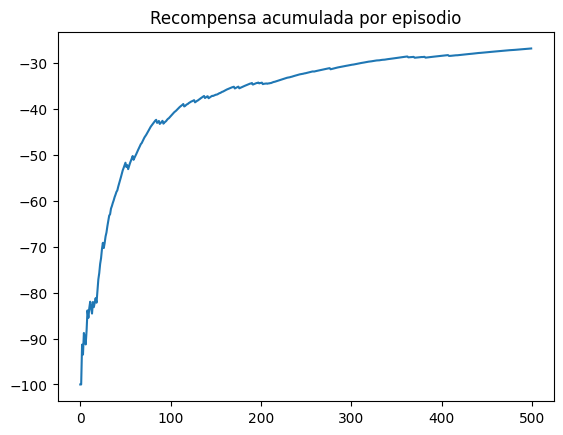

In [316]:
print('SARSA - Baseline')
plot_reward_per_episode(reward_ep_SARSA_baseline)

**`Escenario 1 (sube alpha)`**

El parámetro alpha (tasa de aprendizaje), controla cuánto peso se da a las nuevas experiencias en relación con las experiencias pasadas al actualizar los valores Q. 
Al aumentar el valor de alpha se observa:
*   **Aprendizaje más rápido al principio**: SARSA aprenderá más rápidamente. Con lo cual la curva de recompensa aumenta más rápidamente en los primeros episodios.
*   **Convergencia inestable**: la curva de recompensa se vuelve errática a medida que avanza el entrenamiento. Al final se observa que (comparado con el baseline) termina convergiendo hacia una política subóptima.

SARSA - Scenario 1 (sube alpha)


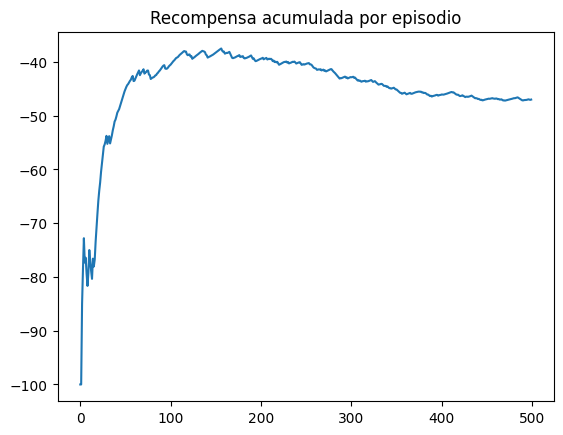

In [317]:
print('SARSA - Scenario 1 (sube alpha)')
plot_reward_per_episode(reward_ep_SARSA_scenario1)

`Escenario 2 (baja gamma)`

El peak de la curva es menor al del baseline. Y aún así, luego de alcanzarlo, sigue cayendo hasta estabilizarse en una política subóptima.

El valor de gamma controla la importancia de las recompensas futuras en relación con las recompensas inmediatas. Al disminuir gamma, el agente se centrará más en obtener recompensas inmediatas. Esto puede hacer que tenga "miopía" y se concentre en obtener recompensas más pequeñas y de corto plazo, incluso si estas decisiones resultan en una recompensa acumulada más baja a largo plazo (converge hacia una política subóptima).

En este juego, que requiere varios pasos antes de llegar a la meta, poner un gamma alto diluye mucho la recompensa final.

SARSA - Scenario 2 (baja gamma)


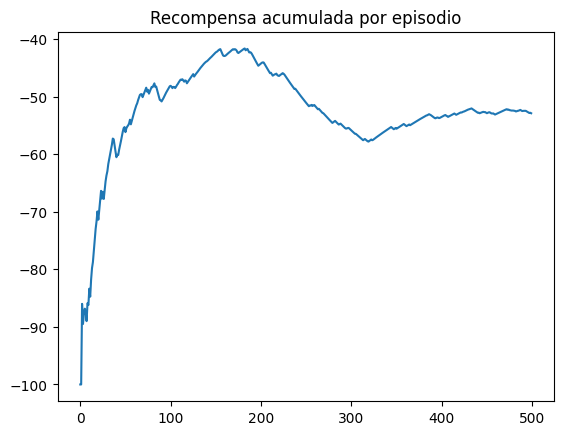

In [318]:
print('SARSA - Scenario 2 (baja gamma)')
plot_reward_per_episode(reward_ep_SARSA_scenario2)

`Escenario 3 (sube epsilon)`

Epsilon controla la probabilidad de que el agente elija una acción aleatoria en lugar de la acción óptima según su política actual (epsilon-greedy). Al aumentar el épsilon se tendrá:

*  **Exploración más agresiva:** el agente será más propenso a explorar acciones aleatorias en lugar de seguir su política actual. Esto conduce a una exploración más agresiva del entorno, ya que el agente elige acciones no óptimas con mayor frecuencia.
*  **Mayor variabilidad en el aprendizaje:** Una exploración más agresiva puede resultar en una mayor variabilidad en las recompensas obtenidas. El agente puede encontrar recompensas más altas y bajas con mayor frecuencia, lo que puede hacer que la curva de recompensa sea más volátil.
*  **Mayor convergencia a políticas subóptimas:** Aumentar epsilon puede hacer que el agente converja hacia políticas subóptimas, ya que se arriesga a elegir acciones no óptimas con mayor frecuencia. Esto puede resultar en una recompensa acumulada más baja en comparación con un valor más bajo de epsilon.

En la curva de recompensa se observa una mayor variabilidad respecto al baseline y a su vez se converge a una política mucho menos óptima.

SARSA - Scenario 3 (sube epsilon)


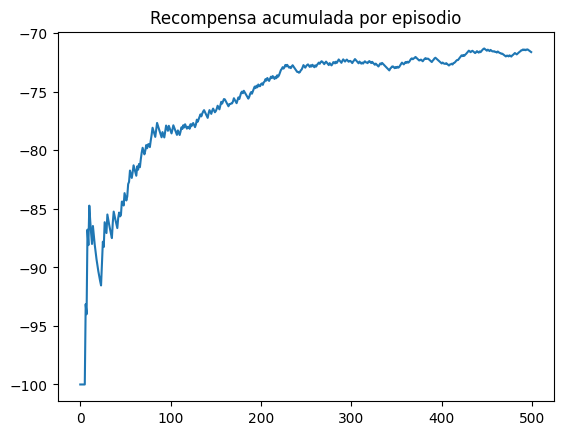

In [319]:
print('SARSA - Scenario 3 (sube epsilon)')
plot_reward_per_episode(reward_ep_SARSA_scenario3)

#### **Cómo afecta a los pasos por episodio**

`Baseline`

SARSA - Baseline


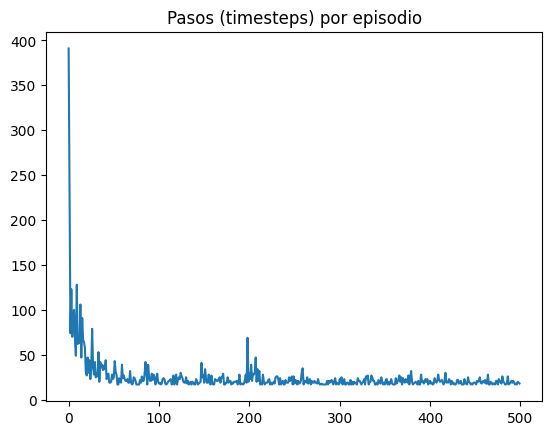

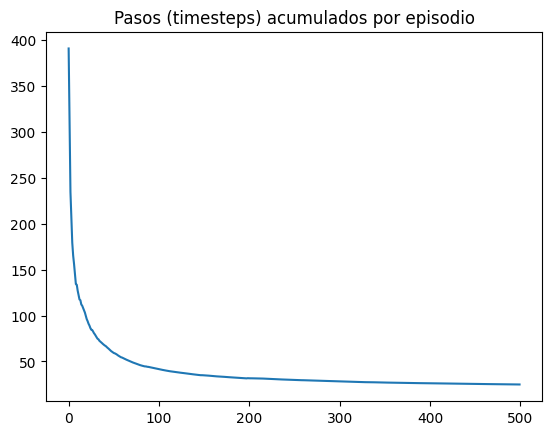

In [320]:
print('SARSA - Baseline')
plot_steps_per_episode(timesteps_ep_SARSA_baseline)
plot_steps_per_episode_smooth(timesteps_ep_SARSA_baseline)

En los 3 escenarios, se observa mucha más variabilidad en los pasos que el baseline.

`Escenario 1 (sube alpha)`

Un mayor valor de alpha permite actualizaciones más grandes en los valores Q. Esto hace que el agente tome decisiones basadas en valores Q que pueden cambiar rápidamente, lo que conduce a una mayor variabilidad en los pasos por episodio. El agente es más propenso a tomar acciones arriesgadas o no óptimas, que no han sido completamente exploradas.

SARSA - Scenario 1 (sube alpha)


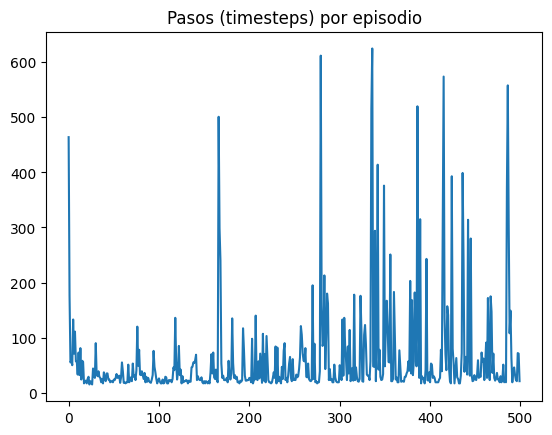

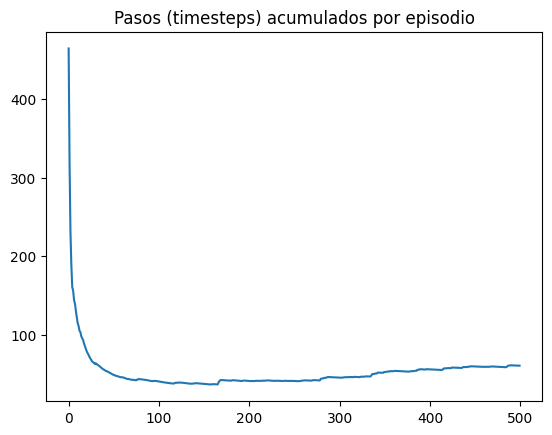

In [321]:
print('SARSA - Scenario 1 (sube alpha)')
plot_steps_per_episode(timesteps_ep_SARSA_scenario1)
plot_steps_per_episode_smooth(timesteps_ep_SARSA_scenario1)

`Escenario 2 (baja gamma)`

Un gamma más bajo puede resultar en un mayor número de pasos por episodio, ya que el agente puede no considerar las acciones a largo plazo que podrían conducir a una finalización más eficiente del episodio. En este entorno, cuantos más pasos, más castigo. Pero si en el futuro el castigo está diluido, quizas al agente le convenga explorar un poco más.

SARSA - Scenario 2 (baja gamma)


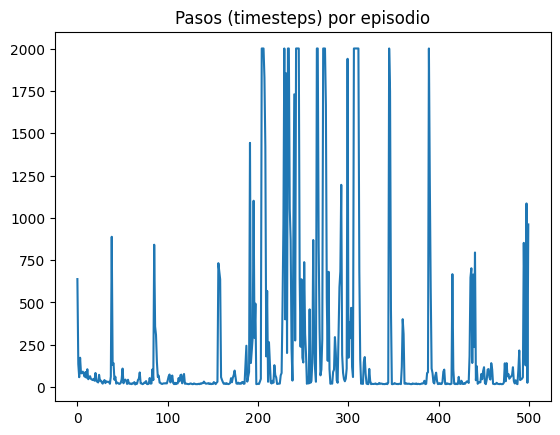

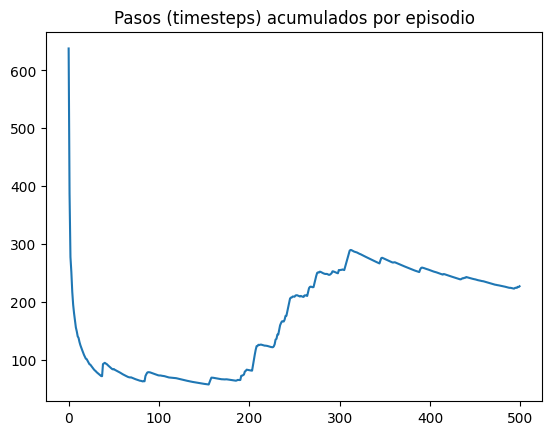

In [322]:
print('SARSA - Scenario 2 (baja gamma)')
plot_steps_per_episode(timesteps_ep_SARSA_scenario2)
plot_steps_per_episode_smooth(timesteps_ep_SARSA_scenario2)

`Escenario 3 (sube epsilon)`

La exploración más agresiva da como resultado una mayor variabilidad en la duración de los episodios, ya que el agente podría tomar acciones subóptimas con mayor frecuencia.

SARSA - Scenario 3 (sube epsilon)


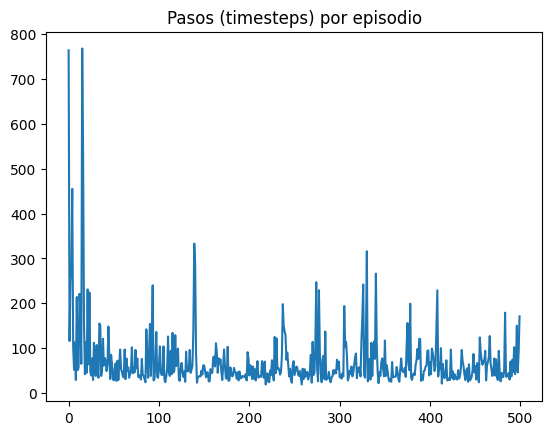

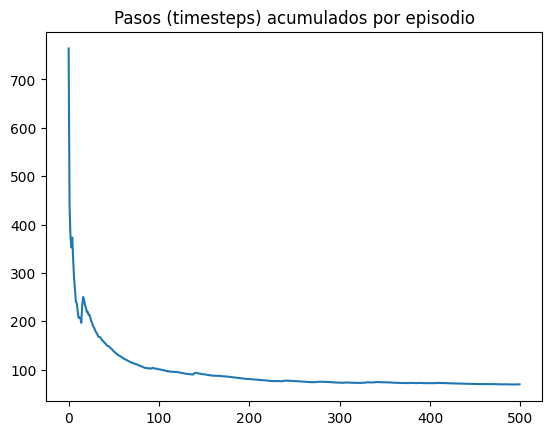

In [323]:
print('SARSA - Scenario 3 (sube epsilon)')
plot_steps_per_episode(timesteps_ep_SARSA_scenario3)
plot_steps_per_episode_smooth(timesteps_ep_SARSA_scenario3)